## MSDS 7333 Project 1 -- Predicting Location via Indoor Positioning Systems

#### Steven Hayden



### Introduction

Our company has been designing an Indoor Positioning System (IPS) to track critical equipment in the office building in near real-time. The technology team built the IPS infrastructure with a set of access points and collected initial readings from defined locations. 

Data Preparation (Q1) - completed in another notebook.

The technology team provided our team with two data sets: the offline data contained signal strength measurements between a hand-held device and each access points at 166 specific locations (Figure 1 grey circles); the online data set with signal strength readings for each access point from which to predict location; and a reference document. The two data sets were large, text files with information provides as strings. Per the documentation, the offline data set contained: time of each reading; the access point identification; the location coordinates of readings; and the orientation between location and access points in degrees; the signal strength of each reading; and data about access point channels, frequencies, and modes. The online data set contained similar information without location coordinates. Given the similar structure between the offline and online data sets, our preparation steps were used on both sets.


The team selected two distinct clustering methods to explore the two data sets: K-Nearest Neighbors (KNN) and Random Forest. KNN will group the most similar items in a data set, depending on the number of neighbors selected. We evaluated k values in a grid serch. 

Data utilized here matches what was done in R vs other versions used more training data. 

In [1]:
import pandas as pd

url_dataset = 'https://raw.githubusercontent.com/jjschueder/7331DataMiningNotebooks/master/Live%20Assignments/df1hotmerge2.csv'
url_dataset1 = 'https://raw.githubusercontent.com/jjschueder/7333QTW/master/Case%20Study%201/Case%20Study%201%20data/trainsskevin.csv'
url_dataset2 = 'https://raw.githubusercontent.com/jjschueder/7333QTW/master/Case%20Study%201/Case%20Study%201%20data/onlinewithcd.csv'
    
onlineSummary = pd.read_csv(url_dataset2)
offlineSummary = pd.read_csv(url_dataset1) 


In [2]:
offlineSummary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166 entries, 0 to 165
Data columns (total 10 columns):
posXY                166 non-null object
posX                 166 non-null int64
posY                 166 non-null int64
00.0f.a3.39.dd.cd    166 non-null float64
00.0f.a3.39.e1.c0    166 non-null float64
00.14.bf.3b.c7.c6    166 non-null float64
00.14.bf.b1.97.81    166 non-null float64
00.14.bf.b1.97.8a    166 non-null float64
00.14.bf.b1.97.8d    166 non-null float64
00.14.bf.b1.97.90    166 non-null float64
dtypes: float64(7), int64(2), object(1)
memory usage: 13.1+ KB


In [3]:
onlineSummary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 13 columns):
Unnamed: 0           60 non-null object
posXY                60 non-null object
posX                 60 non-null float64
posY                 60 non-null float64
orientation          60 non-null float64
angle                60 non-null int64
00:0f:a3:39:dd:cd    60 non-null float64
00:0f:a3:39:e1:c0    60 non-null float64
00:14:bf:3b:c7:c6    60 non-null float64
00:14:bf:b1:97:81    60 non-null float64
00:14:bf:b1:97:8a    60 non-null float64
00:14:bf:b1:97:8d    60 non-null float64
00:14:bf:b1:97:90    60 non-null float64
dtypes: float64(10), int64(1), object(2)
memory usage: 6.2+ KB


In [4]:
# Import all necessary libraries we will be using in our dataset

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
import sklearn
import statistics
import random

from sklearn.feature_selection import SelectKBest, chi2, SelectPercentile, RFE, SelectFromModel

from sklearn.preprocessing import StandardScaler, Binarizer

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, auc, roc_curve
from IPython.display import display, HTML

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, TimeSeriesSplit, StratifiedShuffleSplit

from sklearn.naive_bayes import MultinomialNB

from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor,AdaBoostClassifier,RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

matplotlib.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')



In [5]:
print(onlineSummary.shape)
onlineSummary.head()

(60, 13)


,Unnamed: 0,posXY,posX,posY,orientation,angle,00:0f:a3:39:dd:cd,00:0f:a3:39:e1:c0,00:14:bf:3b:c7:c6,00:14:bf:b1:97:81,00:14:bf:b1:97:8a,00:14:bf:b1:97:8d,00:14:bf:b1:97:90
0,0-0.05,0-0.05,0.00,0.05,130.5,135,-63.207207,-52.227273,-62.948980,-61.813953,-40.068966,-63.043011,-55.233333
1,0.15-9.42,0.15-9.42,0.15,9.42,112.3,90,-66.117117,-55.275229,-73.961905,-72.701031,-47.813084,-69.454545,-46.880000
2,0.31-11.09,0.31-11.09,0.31,11.09,230.1,225,-67.054054,-51.709091,-70.082474,-70.098901,-54.088235,-69.131579,-53.886598
3,0.47-8.2,0.47-8.2,0.47,8.20,5.8,0,-74.153153,-49.500000,-64.258065,-72.597701,-45.652893,-60.797468,-49.580000
4,0.78-10.94,0.78-10.94,0.78,10.94,348.3,0,-71.403670,-53.263636,-66.960000,-66.809524,-48.413793,-65.000000,-54.846939


In [6]:
offlineSummary.head()

,posXY,posX,posY,00.0f.a3.39.dd.cd,00.0f.a3.39.e1.c0,00.14.bf.3b.c7.c6,00.14.bf.b1.97.81,00.14.bf.b1.97.8a,00.14.bf.b1.97.8d,00.14.bf.b1.97.90
0,0-0,0,0,-69.842832,-54.763636,-67.047342,-64.833865,-36.205309,-65.507582,-56.180923
1,0-1,0,1,-70.869697,-52.238365,-64.675620,-65.334544,-38.196630,-67.035534,-57.057283
2,0-10,0,10,-67.979998,-54.452961,-63.591269,-67.666858,-44.928723,-66.241311,-53.344972
3,0-11,0,11,-70.704259,-55.394551,-65.347747,-65.626595,-48.639093,-66.737897,-55.011006
4,0-12,0,12,-68.951855,-55.109091,-67.047620,-69.848739,-43.766125,-70.965432,-53.610353


## Evaluation 1
Within this notebook, we have built models to evaluate location prediction.  This is a multi-classification problem in which our goal is to correctly classify a set of signals as a location in a building.  A detailed description of the metrics we will use to evaluate the models are noted below.


**Error Rate* - 

Predicition are made with the algorithm and compared to known locations.  Each prediction and location has an x and y coordinate. The distance is measured in a 'Pythagorean Theorem' or angular distance.  

              y  
             /   
            /   
           /    
          /    
         x    
We then take the distance as measured above and do a sum and average(mean) of the distance as - dist err mean & dist err sum.



In [98]:
#Source: https://github.com/jakemdrew/EducationDataNC/blob/master/2017/Models/2017ComparingSegregatedMiddleSchoolCampuses.ipynb
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10)


def EvaluateClassifierEstimator(classifierEstimator, X, Y2, cv):



#Perform cross validation 
    scores = cross_validate(classifierEstimator, X, Y2,
                            scoring=['accuracy', 'precision','recall'], 
                            cv=cv, return_train_score=True, 
                            )

    Accavg = scores['test_accuracy'].mean()
    Preavg = scores['test_precision'].mean()
    Rreavg = scores['test_recall'].mean()

    print_str = "The average accuracy for all cv folds is: \t\t\t {Accavg:.5}"
    print_str2 = "The average precision for all cv folds is: \t\t\t {Preavg:.5}"
    print_str3 = "The average Recall for all cv folds is: \t\t\t {Rreavg:.5}"

    print(print_str.format(Accavg=Accavg))
    print(print_str2.format(Preavg=Preavg))
    print(print_str3.format(Rreavg=Rreavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['Accuracy'] = scores['test_accuracy']
    scoresResults['Precision'] = scores['test_precision']
    scoresResults['Recall'] = scores['test_recall']
    print(scoresResults)
    return scoresResults

def EvaluateClassifierEstimator2(classifierEstimator, X, Y2, cv):
    
  #Perform cross validation 
  from sklearn.model_selection import cross_val_predict
  predictions = cross_val_predict(classifierEstimator, 
                                  X, Y2, cv=cv)
    
#model evaluation 
  from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#pass true test set values and predictions to classification_report
  classReport = classification_report(Y2,predictions)
  confMat = confusion_matrix(Y2,predictions)
  acc = accuracy_score(Y2,predictions)
    
  print(classReport)
  print(confMat)
  print(acc)
#from imblearn.over_sampling import SMOTE    
def EvaluateClassifierEstimator3(classifierEstimator, X, Y2, cv):
  from sklearn import metrics as mt
  for fold, (train_index, test_index) in enumerate(cv.split(X,Y2)):
     X_train = X[train_index]    
     y_train = Y2[train_index]  # Based on your code, you might need a ravel call here, but I would look into how you're generating your y
     X_test = X[test_index]
     y_test = Y2[test_index]  # See comment on ravel and  y_train
     sm = SMOTE(random_state=101)
     X_train_oversampled, y_train_oversampled = sm.fit_sample(X_train, y_train)
     classifierEstimator.fit(X_train, y_train) 
     y_pred = classifierEstimator.predict(X_test)
     acc = mt.accuracy_score(y_test,y_pred)
     conf = mt.confusion_matrix(y_test,y_pred)
     print("====Iteration",fold," ====")
     print("accuracy", acc )
     print("confusion matrix\n",conf)


## Evaluation 2


In [99]:
#class percentage split
dfgrp = onlineSummary.groupby(['posXY', 'posX', 'posY'])
onlineSummary['posXY'].value_counts()
dfgrp['posXY'].count() / len(onlineSummary) *100

posXY       posX   posY 
0-0.05      0.00   0.05     1.666667
0.15-9.42   0.15   9.42     1.666667
0.31-11.09  0.31   11.09    1.666667
0.47-8.2    0.47   8.20     1.666667
0.78-10.94  0.78   10.94    1.666667
0.93-11.69  0.93   11.69    1.666667
1.08-12.19  1.08   12.19    1.666667
1.24-3.93   1.24   3.93     1.666667
1.39-6.61   1.39   6.61     1.666667
1.52-9.32   1.52   9.32     1.666667
1.55-0.96   1.55   0.96     1.666667
1.58-5.26   1.58   5.26     1.666667
1.71-1.81   1.71   1.81     1.666667
1.86-8.08   1.86   8.08     1.666667
10.23-6.88  10.23  6.88     1.666667
10.46-5.8   10.46  5.80     1.666667
10.62-3.87  10.62  3.87     1.666667
10.99-7.19  10.99  7.19     1.666667
11.39-5     11.39  5.00     1.666667
11.76-7.76  11.76  7.76     1.666667
12.16-5.25  12.16  5.25     1.666667
12.18-3.4   12.18  3.40     1.666667
12.26-6.72  12.26  6.72     1.666667
12.55-7.38  12.55  7.38     1.666667
12.95-5.25  12.95  5.25     1.666667
14.98-7.55  14.98  7.55     1.666667
16.44-7.45  1

In [100]:
onlineSummary['posXY'].value_counts()

0.31-11.09    1
0.78-10.94    1
16.44-7.45    1
24.7-7.7      1
10.62-3.87    1
25.23-7.78    1
10.23-6.88    1
1.52-9.32     1
2.49-7.6      1
12.16-5.25    1
1.39-6.61     1
24.31-3.89    1
11.39-5       1
0.47-8.2      1
23.24-7.5     1
21.23-5.47    1
1.55-0.96     1
12.18-3.4     1
9.46-7.77     1
9.86-3.88     1
1.58-5.26     1
4.51-7.63     1
7.48-7.36     1
23.53-4.22    1
0.93-11.69    1
21.3-3.8      1
0-0.05        1
3.44-7.43     1
12.55-7.38    1
0.15-9.42     1
14.98-7.55    1
1.86-8.08     1
9.08-7.24     1
1.24-3.93     1
8.56-7.64     1
1.71-1.81     1
26.71-7.5     1
28.12-7.57    1
2.02-7.45     1
21.45-6.62    1
22.38-3.94    1
10.99-7.19    1
31.06-7.19    1
12.95-5.25    1
21.6-7.63     1
25.76-7.34    1
10.46-5.8     1
21.98-7.46    1
29.58-7.93    1
1.08-12.19    1
22.76-5.06    1
6-7.88        1
12.26-6.72    1
31.78-7.62    1
32.54-7.08    1
32.16-7.08    1
11.76-7.76    1
23.36-3.4     1
22.3-6.36     1
23.9-7        1
Name: posXY, dtype: int64

In [101]:
offlineSummary['posXY'].value_counts()

25-3    1
24-3    1
15-3    1
33-3    1
21-6    1
       ..
7-10    1
4-2     1
23-3    1
32-5    1
7-11    1
Name: posXY, Length: 166, dtype: int64

In [102]:
onlineSummary.columns

Index(['Unnamed: 0', 'posXY', 'posX', 'posY', 'orientation', 'angle',
       '00:0f:a3:39:dd:cd', '00:0f:a3:39:e1:c0', '00:14:bf:3b:c7:c6',
       '00:14:bf:b1:97:81', '00:14:bf:b1:97:8a', '00:14:bf:b1:97:8d',
       '00:14:bf:b1:97:90'],
      dtype='object')

In [103]:
offlineSummary.columns

Index(['posXY', 'posX', 'posY', '00.0f.a3.39.dd.cd', '00.0f.a3.39.e1.c0',
       '00.14.bf.3b.c7.c6', '00.14.bf.b1.97.81', '00.14.bf.b1.97.8a',
       '00.14.bf.b1.97.8d', '00.14.bf.b1.97.90'],
      dtype='object')

In [104]:
onlineSummary.head()

,Unnamed: 0,posXY,posX,posY,orientation,angle,00:0f:a3:39:dd:cd,00:0f:a3:39:e1:c0,00:14:bf:3b:c7:c6,00:14:bf:b1:97:81,00:14:bf:b1:97:8a,00:14:bf:b1:97:8d,00:14:bf:b1:97:90
0,0-0.05,0-0.05,0.00,0.05,130.5,135,-63.207207,-52.227273,-62.948980,-61.813953,-40.068966,-63.043011,-55.233333
1,0.15-9.42,0.15-9.42,0.15,9.42,112.3,90,-66.117117,-55.275229,-73.961905,-72.701031,-47.813084,-69.454545,-46.880000
2,0.31-11.09,0.31-11.09,0.31,11.09,230.1,225,-67.054054,-51.709091,-70.082474,-70.098901,-54.088235,-69.131579,-53.886598
3,0.47-8.2,0.47-8.2,0.47,8.20,5.8,0,-74.153153,-49.500000,-64.258065,-72.597701,-45.652893,-60.797468,-49.580000
4,0.78-10.94,0.78-10.94,0.78,10.94,348.3,0,-71.403670,-53.263636,-66.960000,-66.809524,-48.413793,-65.000000,-54.846939


In [108]:
%%time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import metrics as mt

cv = StratifiedKFold(n_splits=10)

featuresoff = ['00.0f.a3.39.dd.cd', '00.0f.a3.39.e1.c0',
       '00.14.bf.3b.c7.c6', '00.14.bf.b1.97.81', '00.14.bf.b1.97.8a',
       '00.14.bf.b1.97.8d', '00.14.bf.b1.97.90']

featureson = ['00:0f:a3:39:dd:cd', '00:0f:a3:39:e1:c0', '00:14:bf:3b:c7:c6',
       '00:14:bf:b1:97:81', '00:14:bf:b1:97:8a', '00:14:bf:b1:97:8d',
       '00:14:bf:b1:97:90']
        
X2 = offlineSummary[featuresoff].copy()
X3 = onlineSummary[featureson].copy()
scaler = StandardScaler()
scaler.fit(X2)

#This makes our model's coefficients take on the same scale for accurate feature importance analysis
#Notice we scaled the data before the cross validation
X = scaler.transform(X2)
X = offlineSummary[featuresoff].copy()
Y= offlineSummary[['posXY']].copy()
Y3= onlineSummary[['posXY']].copy()
Y2 = Y.values

#Divide data into test and training splits
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=2, test_size=0.20, random_state=0)

Wall time: 12 ms


In [109]:
from sklearn import metrics as mt

# train and test split before resampling
X1_train, X1_test, y1_train, y1_test = train_test_split(X, Y, test_size = 0.01, random_state = 101) 


## Classification 


### Task 1 - Modeling and Evaluation 3
Create different classification models for each task e.g., random forest, KNN. 

The algorithms used are as follows:  

*   K-Nearest Neighbor
*   Random Forest Classification


#### Model 1: KNN Classification

In [188]:

param_grid = [
    {
         'weights': ['distance','uniform'],
         'leaf_size': [5,10, 20],
         'metric': ['minkowski','euclidean', 'manhattan'],
         'n_neighbors':[8],
         
    }
]
#2,3,5, 6,7,
#,
clf_KNN = KNeighborsClassifier()
grid_search_KNN = GridSearchCV(clf_KNN, param_grid=param_grid,cv=cv,n_jobs=-1, verbose=1, scoring='accuracy' )

KNearest_model1 = grid_search_KNN.fit(X, Y)

y_KNN_score1 = KNearest_model1.predict(X1_test)



Fitting 2 folds for each of 18 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    0.1s finished


In [189]:
classifierEstimaterKNN1 = KNearest_model1.best_estimator_
classifierEstimaterKNN1


KNeighborsClassifier(algorithm='auto', leaf_size=5, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=8, p=2,
                     weights='distance')

According to our grid search, the best estimator is to include 8 neighbors, a leaf size of 5 and a minkowski metric to learn from. 

In [190]:
#import pickle
#filename = r'C:/Users/jjsch/Documents/GitHub/7331lab1/7331DataMiningNotebooks/lab2/classifierEstimaterKNN1.pickle'
#infile = open(filename,'rb')
#classifierEstimaterKNN1 = pickle.loads(infile)
#infile.close()
#outfile = open(filename,'wb')
#pickle.dumps(classifierEstimaterKNN1, filename)
#from joblib import dump, load
#dump(classifierEstimaterKNN1, filename)

In [191]:
y_KNN_score1 = classifierEstimaterKNN1.predict(X3)
y_KNN_score1

array(['0-4', '13-1', '10-1', '9-2', '0-11', '13-1', '0-11', '2-2', '9-1',
       '9-1', '0-4', '4-1', '1-1', '7-4', '8-8', '6-10', '4-12', '4-9',
       '6-12', '5-12', '13-5', '3-12', '7-12', '7-10', '13-3', '19-8',
       '17-7', '6-1', '9-2', '23-5', '21-3', '17-7', '22-6', '19-8',
       '26-5', '23-7', '26-3', '20-3', '19-3', '25-3', '20-3', '24-6',
       '22-6', '26-7', '25-8', '26-7', '24-7', '29-7', '8-2', '31-3',
       '29-8', '31-7', '33-8', '6-1', '3-5', '3-5', '7-8', '7-9', '8-11',
       '5-10'], dtype=object)

### Error Measure
Various bits of code to compare test prediction to actuals, cacluate the distance and error.

In [194]:
Y3.head()

,posXY
0,0-0.05
1,0.15-9.42
2,0.31-11.09
3,0.47-8.2
4,0.78-10.94


In [195]:
y1_test = Y3['posXY'].str.split("-", n = 1, expand = True)

In [196]:
yscore = pd.DataFrame(y_KNN_score1)

In [197]:
yscore=yscore[0].str.split("-", n = 1, expand = True)

In [198]:
yscore.head()

,0,1
0,0,4
1,13,1
2,10,1
3,9,2
4,0,11


In [199]:
y1_test[0] = y1_test[0].astype(float) 
y1_test[0] = y1_test[0].round()
y1_test[1] = y1_test[1].astype(float) 
y1_test[1] = y1_test[1].round()
y1_test.head()

,0,1
0,0.0,0.0
1,0.0,9.0
2,0.0,11.0
3,0.0,8.0
4,1.0,11.0


In [200]:
y1_test = y1_test.reset_index()
y1_test.index

RangeIndex(start=0, stop=60, step=1)

In [201]:
yscore.head()

,0,1
0,0,4
1,13,1
2,10,1
3,9,2
4,0,11


In [202]:
ygroup2 = y1_test.reset_index()
ygroup2 = pd.merge(ygroup2, yscore, left_index=True, right_index=True)
ygroup2.head()


,level_0,index,0_x,1_x,0_y,1_y
0,0,0,0.0,0.0,0,4
1,1,1,0.0,9.0,13,1
2,2,2,0.0,11.0,10,1
3,3,3,0.0,8.0,9,2
4,4,4,1.0,11.0,0,11


In [203]:

ygroup2['0_x'] = ygroup2['0_x'].astype(float) 
ygroup2['1_x'] = ygroup2['1_x'].astype(float) 
ygroup2['0_y'] = ygroup2['0_y'].astype(float) 
ygroup2['1_y'] = ygroup2['1_y'].astype(float) 
ygroup2['xdist'] = ygroup2['0_x'] - ygroup2['0_y']
ygroup2['ydist'] = ygroup2['1_x'] - ygroup2['1_y']
ygroup2['obatuple'] = ygroup2[['0_x', '1_x']].apply(tuple, axis=1)
ygroup2['obttuple'] = ygroup2[['0_y', '1_y']].apply(tuple, axis=1) 

In [204]:
ygroup2['xsqr'] = (ygroup2['0_x'] - ygroup2['0_y'])**2
ygroup2['ysqr'] = (ygroup2['1_x'] - ygroup2['1_y'])**2

In [205]:
ygroup2['distance'] = ygroup2['xsqr'] + ygroup2['ysqr']

In [206]:
ygroup2['distancefinalerror'] = np.sqrt(ygroup2['distance'])

In [207]:
ygroup2.head()

,level_0,index,0_x,1_x,0_y,1_y,xdist,ydist,obatuple,obttuple,xsqr,ysqr,distance,distancefinalerror
0,0,0,0.0,0.0,0.0,4.0,0.0,-4.0,"(0.0, 0.0)","(0.0, 4.0)",0.0,16.0,16.0,4.000000
1,1,1,0.0,9.0,13.0,1.0,-13.0,8.0,"(0.0, 9.0)","(13.0, 1.0)",169.0,64.0,233.0,15.264338
2,2,2,0.0,11.0,10.0,1.0,-10.0,10.0,"(0.0, 11.0)","(10.0, 1.0)",100.0,100.0,200.0,14.142136
3,3,3,0.0,8.0,9.0,2.0,-9.0,6.0,"(0.0, 8.0)","(9.0, 2.0)",81.0,36.0,117.0,10.816654
4,4,4,1.0,11.0,0.0,11.0,1.0,0.0,"(1.0, 11.0)","(0.0, 11.0)",1.0,0.0,1.0,1.000000


In [208]:
ygroup2['distancefinalerror'].mean()

4.968026858587331

In [209]:
ygroup2['distancefinalerror'].sum()

298.0816115152398

In [210]:
x1, x2, y1, y2 = None,None,None,None

In [211]:
ygroup2.tail()

,level_0,index,0_x,1_x,0_y,1_y,xdist,ydist,obatuple,obttuple,xsqr,ysqr,distance,distancefinalerror
55,55,55,7.0,7.0,3.0,5.0,4.0,2.0,"(7.0, 7.0)","(3.0, 5.0)",16.0,4.0,20.0,4.472136
56,56,56,9.0,8.0,7.0,8.0,2.0,0.0,"(9.0, 8.0)","(7.0, 8.0)",4.0,0.0,4.0,2.000000
57,57,57,9.0,7.0,7.0,9.0,2.0,-2.0,"(9.0, 7.0)","(7.0, 9.0)",4.0,4.0,8.0,2.828427
58,58,58,9.0,8.0,8.0,11.0,1.0,-3.0,"(9.0, 8.0)","(8.0, 11.0)",1.0,9.0,10.0,3.162278
59,59,59,10.0,4.0,5.0,10.0,5.0,-6.0,"(10.0, 4.0)","(5.0, 10.0)",25.0,36.0,61.0,7.810250


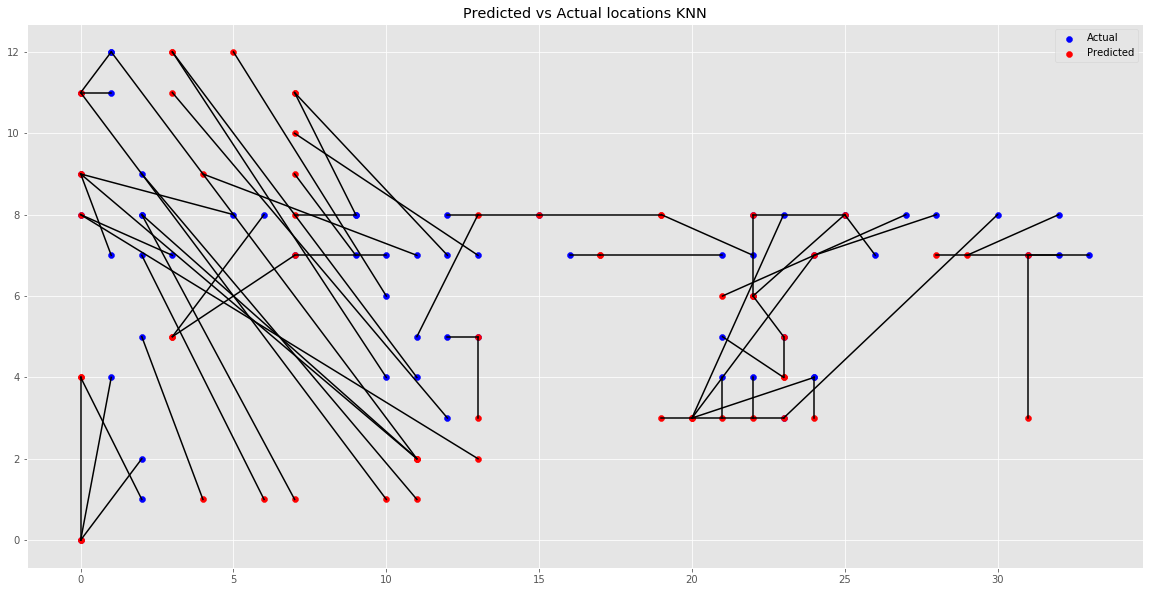

In [134]:
plt.figure(figsize=(20,10))
plt.title('Predicted vs Actual locations KNN')
for i, row in ygroup2.iterrows():
    x1, x2 = ygroup2.loc[i,'0_x'], ygroup2.loc[i,'0_y']
    y1, y2 = ygroup2.loc[i,'1_x'], ygroup2.loc[i,'1_y']
    plt.plot([x1,x2], [y1,y2],'k-')
#plt.scatter(ygroup2['0_x'], ygroup2['1_x'], c = 'blue', label = 'Actual')
#plt.scatter(ygroup2['0_y'], ygroup2['1_y'], c = 'red', label = 'Predicted')
p1 = plt.scatter(ygroup2['0_x'], ygroup2['1_x'], c = 'blue', label = 'Actual')
p2 = plt.scatter(ygroup2['0_y'], ygroup2['1_y'], c = 'red', label = 'Predicted')
plt.legend((p1, p2), ('Actual', 'Predicted'))



#### Model 2: Random Forest Classification

In [135]:
param_grid = [
    {
         'n_estimators': [200, 500], 
         'max_depth': [20,30,35],
         'random_state':[101]
     }
]

clf_RF = RandomForestClassifier()
grid_search_RF = GridSearchCV(clf_RF, param_grid=param_grid, cv=cv,n_jobs=-1, verbose=1, scoring='accuracy' )

RandomForest_model1 = grid_search_RF.fit(X, Y)

y_RF_score1 = RandomForest_model1.predict(X3)


Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    1.8s finished


In [212]:
param_grid = [
    {'bootstrap': [True, False],
     'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10],
     'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
          }
]

clf_RF = RandomForestClassifier()
grid_search_RF = GridSearchCV(clf_RF, param_grid=param_grid, cv=cv,n_jobs=-1, verbose=1, scoring='accuracy' )

RandomForest_model1 = grid_search_RF.fit(X, Y)

y_RF_score1 = RandomForest_model1.predict(X3)

Fitting 2 folds for each of 3960 candidates, totalling 7920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 21.7min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 28.0min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 36.5min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 49.8min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 66.8min
[Parallel(n_jobs=-1)]: Done 7920 out of 7920 | elapsed: 78.7min finished


In [213]:
yrfscore = pd.DataFrame(y_RF_score1)
yrfscore=yrfscore[0].str.split("-", n = 1, expand = True)

In [214]:
classifierEstimaterRF1 = RandomForest_model1.best_estimator_
classifierEstimaterRF1

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

After running our Random Forest procedure, we can see the grid search selected, a max depth of 20, a number of estimators split of 500 and no warm start with our model. 

In [215]:
ygroup3 = y1_test.reset_index()
ygroup3 = pd.merge(ygroup3, yrfscore, left_index=True, right_index=True)
ygroup3['obatuple'] = ygroup3[['0_x', '0_y']].apply(tuple, axis=1)
ygroup3['obttuple'] = ygroup3[['1_x', '1_y']].apply(tuple, axis=1)
ygroup3['0_x'] = ygroup3['0_x'].astype(float) 
ygroup3['1_x'] = ygroup3['1_x'].astype(float) 
ygroup3['0_y'] = ygroup3['0_y'].astype(float) 
ygroup3['1_y'] = ygroup3['1_y'].astype(float) 
ygroup3['xdist'] = ygroup3['0_x'] - ygroup3['0_y']
ygroup3['ydist'] = ygroup3['1_x'] - ygroup3['1_y']
ygroup3['xsqr'] = (ygroup3['0_x'] - ygroup3['0_y'])**2
ygroup3['ysqr'] = (ygroup3['1_x'] - ygroup3['1_y'])**2
ygroup3['distance'] = ygroup3['xsqr'] + ygroup3['ysqr']
ygroup3['distancefinalerror'] = np.sqrt(ygroup3['distance'])

ygroup3['obatuple'] = ygroup3[['0_x', '1_x']].apply(tuple, axis=1)
ygroup3['obttuple'] = ygroup3[['0_y', '1_y']].apply(tuple, axis=1) 
ygroup3.head()

,level_0,index,0_x,1_x,0_y,1_y,obatuple,obttuple,xdist,ydist,xsqr,ysqr,distance,distancefinalerror
0,0,0,0.0,0.0,6.0,2.0,"(0.0, 0.0)","(6.0, 2.0)",-6.0,-2.0,36.0,4.0,40.0,6.324555
1,1,1,0.0,9.0,11.0,2.0,"(0.0, 9.0)","(11.0, 2.0)",-11.0,7.0,121.0,49.0,170.0,13.038405
2,2,2,0.0,11.0,12.0,1.0,"(0.0, 11.0)","(12.0, 1.0)",-12.0,10.0,144.0,100.0,244.0,15.620499
3,3,3,0.0,8.0,13.0,2.0,"(0.0, 8.0)","(13.0, 2.0)",-13.0,6.0,169.0,36.0,205.0,14.317821
4,4,4,1.0,11.0,0.0,11.0,"(1.0, 11.0)","(0.0, 11.0)",1.0,0.0,1.0,0.0,1.0,1.000000


In [216]:
ygroup3['distancefinalerror'].mean()

5.971018655138044

In [217]:
ygroup3['distancefinalerror'].sum()

358.26111930828273

Text(0.5,1,'Actual and predicted values')

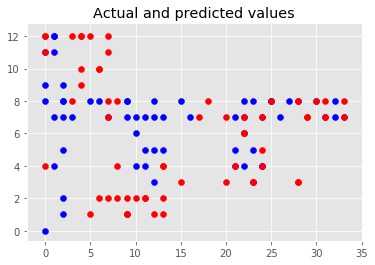

In [218]:
plt.figure(figsize=(20,10))
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
plt.scatter(ygroup3['0_x'], ygroup3['1_x'], c = 'blue', label = 'Actual')
plt.scatter(ygroup3['0_y'], ygroup3['1_y'], c = 'red', label = 'Predicted')


plt.title('Actual and predicted values')


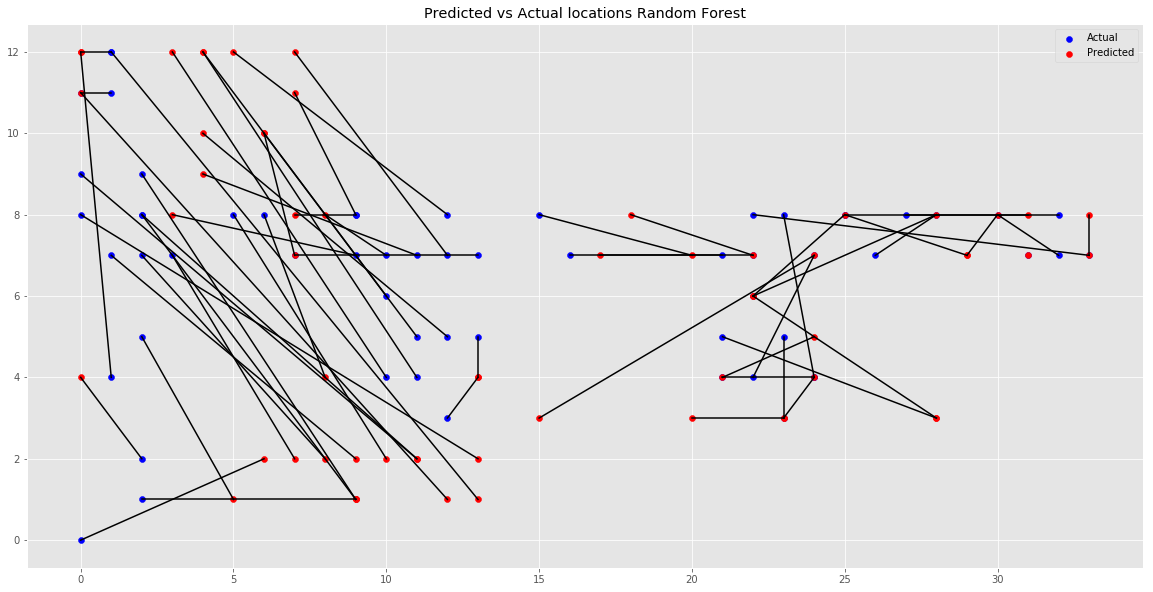

In [219]:
plt.figure(figsize=(20,10))
plt.title('Predicted vs Actual locations Random Forest')
for i, row in ygroup3.iterrows():
    x1, x2 = ygroup3.loc[i,'0_x'], ygroup3.loc[i,'0_y']
    y1, y2 = ygroup3.loc[i,'1_x'], ygroup3.loc[i,'1_y']
    plt.plot([x1,x2], [y1,y2],'k-')
p1 = plt.scatter(ygroup3['0_x'], ygroup3['1_x'], c = 'blue', label = 'Actual')
p2 = plt.scatter(ygroup3['0_y'], ygroup3['1_y'], c = 'red', label = 'Predicted')
plt.legend((p1, p2), ('Actual', 'Predicted'))